In [ ]:
#################
# Preprocessing #
#################
# Scores by other composers from the Bach family have been removed beforehand. 
# Miscellaneous scores like mass pieces have also been removed; the assumption here is that
# since different interpretations of the same piece (e.g. Ave Maria, etc) exist, including
# theses pieces might hurt the prediction accuracy, here mostly based on chord progression. 
# (more exactly, a reduced version of the chord progression.)

# In shell, find and copy midi files to target data directory and convert to mxl:
'''
cd {TARGETDIR}
find {MIDIFILEDIR} \( -name "bach*.mid" -o -name "beethoven*.mid" -o -name "scarlatti*.mid" \) -type f -exec cp {} . \;
find . -type f -name "*.mid" -exec /Applications/MuseScore\ 2.app/Contents/MacOS/mscore {} --export-to {}.mxl \;
for f in *.mxl; do mv "$f" "${f%.mid.mxl}.mxl"; done
ls *.mxl > mxl_list.txt
'''

In [1]:
from music21 import *
from os import listdir
from os.path import isfile, getsize

In [2]:
# timeout function that lets move on beyond too big files.
# by Thomas Ahle: http://stackoverflow.com/a/22348885
import signal

class timeout:
    def __init__(self, seconds=1, error_message='Timeout'):
        self.seconds = seconds
        self.error_message = error_message
    def handle_timeout(self, signum, frame):
        raise TimeoutError(self.error_message)
    def __enter__(self):
        signal.signal(signal.SIGALRM, self.handle_timeout)
        signal.alarm(self.seconds)
    def __exit__(self, type, value, traceback):
        signal.alarm(0)

In [3]:
def parse(mxllist, composer):
    composer_list = [f for f in mxllist if f.replace('-', '_').split('_')[0] == composer]
    for file in composer_list:
        if (getsize(file)>10000): # remove too short scores that may contain no notes
            with timeout(seconds=6000):
                try:
                    s = converter.parse(mxldir+file)
                    try:
                        k = s.flat.keySignature.sharps
                    except AttributeError:
                        k = s.analyze('key').sharps
                    except:
                        with open('{}-parsed.txt'.format(composer), 'a') as output_file:            
                            output_file.write('key could not by analyzed\n')
                        with open('{}-transposed.txt'.format(composer), 'a') as output_file:            
                            output_file.write('key could not by analyzed\n')
                        continue
                    t = s.transpose(k)
                except:
                    with open('{}-parsed.txt'.format(composer), 'a') as output_file:
                        output_file.write('timeout\n')
                    with open('{}-transposed.txt'.format(composer), 'a') as output_file:            
                        output_file.write('timeout\n')
                    continue

            fp_s = converter.freeze(s, fmt='pickle')
            fp_t = converter.freeze(t, fmt='pickle')

            with open('{}-parsed.txt'.format(composer), 'a') as output_file:
                output_file.write(fp_s+'\n')
            with open('{}-transposed.txt'.format(composer), 'a') as output_file:            
                output_file.write(fp_t+'\n')

In [ ]:
with open('mxl_list.txt', 'r') as f:
    mxllist = [line.strip() for line in f.readlines()]

parse(mxllist, 'bach')
parse(mxllist, 'beethoven')
parse(mxllist, 'scarlatti')

In [ ]:
######################
# Feature Extraction #
######################

In [4]:
import itertools
from collections import Counter

flatten = lambda l: [item for sublist in l for item in sublist] # by Alex Martinelli & Guillaume Jacquenot: http://stackoverflow.com/a/952952
uniqify = lambda seq: list(set(seq))

In [5]:
# Define known chords
major, minor, suspended, augmented, diminished, major_sixth, minor_sixth, dominant_seventh, major_seventh, minor_seventh, half_diminished_seventh, diminished_seventh, major_ninth, dominant_ninth, dominant_minor_ninth, minor_ninth = [0,4,7],[0,3,7],[0,5,7],[0,4,8],[0,3,6],[0,4,7,9],[0,3,7,9],[0,4,7,10],[0,4,7,11],[0,3,7,10],[0,3,6,10],[0,3,6,9],[0,2,4,7,11],[0,2,4,7,10],[0,1,4,7,10],[0,2,3,7,10]
chord_types_list = [major, minor, suspended, augmented, diminished, major_sixth, minor_sixth, dominant_seventh, major_seventh, minor_seventh, half_diminished_seventh, diminished_seventh, major_ninth, dominant_ninth, dominant_minor_ninth, minor_ninth]
chord_types_string = ['major', 'minor', 'suspended', 'augmented', 'diminished', 'major_sixth', 'minor_sixth', 'dominant_seventh', 'major_seventh', 'minor_seventh', 'half_diminished_seventh', 'diminished_seventh', 'major_ninth', 'dominant_ninth', 'dominant_minor_ninth', 'minor_ninth']

roots = list(range(12))
chord_orders = flatten([[{(n+r)%12 for n in v} for v in chord_types_list] for r in roots])
unique_orders = []
for i in range(192):
    if chord_orders[i] not in unique_orders:
        unique_orders.append(chord_orders[i])

In [6]:
def merge_chords(s):
    sf = s.flat
    chords_by_offset = []
    for i in range(int(sf.highestTime)):
        chords_by_offset.append(chord.Chord(sf.getElementsByOffset(i,i+1, includeEndBoundary=False, mustFinishInSpan=False, mustBeginInSpan=False).notes))
    return chords_by_offset

def find_neighbor_note(n, k):
    # find notes k steps away from n
    return (roots[n-6:]+roots[:(n+6)%12])[6+k], (roots[n-6:]+roots[:(n+6)%12])[6-k]

def find_note_distance(n1, n2):
    return abs(6 - (roots[n1-6:]+roots[:(n1+6)%12]).index(n2))

def find_chord_distance(set1, set2):
    d1, d2 = set1.difference(set2), set2.difference(set1)
    if len(d1) < len(d2):
        longer, shorter = d2, list(d1)
    else:
        longer, shorter = d1, list(d2)
    distances = []
    for combination in itertools.combinations(longer, len(shorter)):
        for permutation in itertools.permutations(combination):
            dist_p = abs(len(d1)-len(d2))*3 # length difference means notes need to be added/deleted. weighted by 3
            for i in range(len(shorter)):
                dist_p += find_note_distance(shorter[i], permutation[i])
            distances.append(dist_p)
    return min(distances)

In [7]:
CACHE = dict()

def find_closest_chord(c, cache=CACHE):
    if len(c) == 0:
        return -1 # use -1 for rest (chords are 0 to 191)
    
    # retrieve from existing knowledge
    o_str, o, p = str(c.normalOrder), set(c.normalOrder), c.pitchClasses
    if o in chord_orders:
        return chord_orders.index(o)
        # the above root sometimes differs from c.findRoot(), which might be more reliable.
        # however, the errors are rare and it should be good enough for now.
    if o_str in cache.keys():
        return cache[o_str]
    
    # find closest chord from scratch
    chord_distances = dict()
    most_common_note = Counter(c.pitchClasses).most_common(1)[0][0]

    for i in range(192):
        d = find_chord_distance(o, chord_orders[i])
        # prioritize found chord's root note if most common note of the chord.
        if int(i/16) == most_common_note:
            d += -1
        if chord_distances.get(d) == None:
            chord_distances[d] = []
        chord_distances[d].append(i)

    # if multiple chords are tied, use first one (could be better)
    closest_chord = chord_distances[min(chord_distances.keys())][0]
    
    cache[o_str] = closest_chord
    return closest_chord

In [8]:
def extract_features(parsed_list, transposed_list, idx):
    s = converter.thaw(parsed_list[idx])
    st = converter.thaw(transposed_list[idx])
    chords_by_offset = merge_chords(st)
    try:
        k = s.analyze('key') # try-except clause redundant with parse(), should be removed
    except:
        return ('skipped file', idx)
    r = [roman.romanNumeralFromChord(c, k).romanNumeralAlone if len(c)>0 else 'rest' for c in chords_by_offset]
    
    chord_tuples = []
    for i in range(len(chords_by_offset)):
        chord_tuples.append((find_closest_chord(chords_by_offset[i], CACHE), r[i]))
    return chord_tuples

In [ ]:
with open('bach-parsed.txt', 'r') as f:
    FILES_BACH = [line.strip() for line in f.readlines()]
with open('beethoven-parsed.txt', 'r') as f:
    FILES_BEETHOVEN = [line.strip() for line in f.readlines()]
with open('scarlatti-parsed.txt', 'r') as f:
    FILES_SCARLATTI = [line.strip() for line in f.readlines()]
with open('bach-transposed.txt', 'r') as f:
    FILES_BACH_TRANSPOSED = [line.strip() for line in f.readlines()]
with open('beethoven-transposed.txt', 'r') as f:
    FILES_BEETHOVEN_TRANSPOSED = [line.strip() for line in f.readlines()]
with open('scarlatti-transposed.txt', 'r') as f:
    FILES_SCARLATTI_TRANSPOSED = [line.strip() for line in f.readlines()]
    
for i in range(len(FILES_BACH)):
    with open('bach-chordtuples.txt', 'a') as f:
        f.write(str(extract_features(FILES_BACH, FILES_BACH_TRANSPOSED, i))+'\n')
for i in range(len(FILES_BEETHOVEN)):
    with open('beethoven-chordtuples.txt', 'a') as f:
        f.write(str(extract_features(FILES_BEETHOVEN, FILES_BEETHOVEN_TRANSPOSED, i))+'\n')
for i in range(len(FILES_SCARLATTI)):
    with open('scarlatti-chordtuples.txt', 'a') as f:
        f.write(str(extract_features(FILES_SCARLATTI, FILES_SCARLATTI_TRANSPOSED, i))+'\n')

In [ ]:
##################
# Classification #
##################

In [9]:
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
from sklearn import svm, linear_model, naive_bayes, neural_network, neighbors
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
from sklearn import ensemble
import random, math
import numpy as np

In [10]:
with open('bach-chordtuples.txt', 'r') as f:
    BACH = [l.strip().strip('[]').replace("'", '').replace('(','').replace(')','').split(', ') for l in f]
with open('beethoven-chordtuples.txt', 'r') as f:
    BEETHOVEN = [l.strip().strip('[]').replace("'", '').replace('(','').replace(')','').split(', ') for l in f]
with open('scarlatti-chordtuples.txt', 'r') as f:
    SCARLATTI = [l.strip().strip('[]').replace("'", '').replace('(','').replace(')','').split(', ') for l in f]

In [11]:
def find_ngrams(input_list, N=4):
    return [' '.join(input_list[i:i+N]) for i in range(len(input_list)-N+1)]

def ngrams_by_composer(composer): 
    composer_tuples = [[(int(piece[i*2]), piece[i*2+1]) for i in range(int(len(piece)/2))] for piece in composer]
    chordorders = [' '.join([str(t[0]) for t in piece]) for piece in composer_tuples]
    romannumerals = [' '.join([t[1] for t in piece]) for piece in composer_tuples]
    for i in range(1,7):
        ngrams_c = []
        ngrams_r = []
        for piece in chordorders:
            ngrams_c += find_ngrams(piece.split(' '), i)
        for piece in romannumerals:
            ngrams_r += find_ngrams(piece.split(' '), i)
        print('Chord Orders  :', len(ngrams_c), '{}-grams total;'.format(str(i)), len(set(ngrams_c)), 'unique')
        print('Roman Numerals:', len(ngrams_r), '{}-grams total;'.format(str(i)), len(set(ngrams_r)), 'unique')
        if i == 1:
            print(set(ngrams_r))
    print('-')

In [150]:
print('Bach:', len(BACH), 'pieces')
ngrams_by_composer(BACH)
print('Beethoven:', len(BEETHOVEN), 'pieces')
ngrams_by_composer(BEETHOVEN)
print('Scarlatti:', len(SCARLATTI), 'pieces')
ngrams_by_composer(SCARLATTI)
print('Full dataset:', len(BACH+BEETHOVEN+SCARLATTI), 'pieces')
ngrams_by_composer(BACH+BEETHOVEN+SCARLATTI)

Bach: 2119 pieces
Chord Orders  : 662671 1-grams total; 176 unique
Roman Numerals: 662671 1-grams total; 15 unique
{'V', 'VII', 'rest', 'v', 'III', 'II', 'iv', 'IV', 'iii', 'I', 'VI', 'i', 'vii', 'vi', 'ii'}
Chord Orders  : 660552 2-grams total; 17433 unique
Roman Numerals: 660552 2-grams total; 225 unique
Chord Orders  : 658433 3-grams total; 157590 unique
Roman Numerals: 658433 3-grams total; 3051 unique
Chord Orders  : 656314 4-grams total; 328010 unique
Roman Numerals: 656314 4-grams total; 33927 unique
Chord Orders  : 654195 5-grams total; 417513 unique
Roman Numerals: 654195 5-grams total; 153650 unique
Chord Orders  : 652076 6-grams total; 455023 unique
Roman Numerals: 652076 6-grams total; 296111 unique
-
Beethoven: 667 pieces
Chord Orders  : 631995 1-grams total; 175 unique
Roman Numerals: 631995 1-grams total; 15 unique
{'V', 'v', 'VII', 'rest', 'III', 'II', 'iv', 'IV', 'iii', 'I', 'VI', 'i', 'vii', 'vi', 'ii'}
Chord Orders  : 631328 2-grams total; 18098 unique
Roman Numerals

In [14]:
# def build_Xy(composer0, composer1, vectorizer, feature='chordorders', n_size=0):
#     if n_size == 0: # use every rows
#         ix0, ix1 = range(len(composer0)), range(len(composer1))
#     else:
#         ix0, ix1 = random.sample(range(len(composer0)), n_size), random.sample(range(len(composer1)), n_size)

#     y = np.array([0 for i in range(len(ix0))] + [1 for i in range(len(ix1))])
    
#     composer0_tuples = [[(int(piece[i*2]), piece[i*2+1]) for i in range(int(len(piece)/2))] for piece in composer0]
#     composer1_tuples = [[(int(piece[i*2]), piece[i*2+1]) for i in range(int(len(piece)/2))] for piece in composer1]

#     if feature == 'chordorders':
#         chordorders0 = [' '.join([str(t[0]) for t in piece]) for piece in composer0_tuples]
#         chordorders1 = [' '.join([str(t[0]) for t in piece]) for piece in composer1_tuples]
#         X = [chordorders0[i] for i in ix0] + [chordorders1[i] for i in ix1]
#     if feature == 'romannumerals':
#         romannumerals0 = [' '.join([t[1] for t in piece]) for piece in composer0_tuples]
#         romannumerals1 = [' '.join([t[1] for t in piece]) for piece in composer1_tuples]
#         X = [romannumerals0[i] for i in ix0] + [romannumerals1[i] for i in ix1]
    
#     X = vectorizer.fit_transform((piece for piece in X))
#     return X, y

In [12]:
def build_Xy(composers, vectorizer, feature='chordorders', n_size=0):
    if n_size == 0: # use every rows
        indices = [range(len(composer)) for composer in composers]
    else:
        indices = [random.sample(range(len(composer)), n_size) for composer in composers]

    y = []
    for i in range(len(composers)):
        y += [i for n in range(len(indices[i]))]
    y = np.array(y, dtype='int16')
    
    X = []
    chords = [[' '.join([piece[i] for i in range(0, len(piece), 2)]) for piece in composer] for composer in composers]
    for i in range(len(composers)):
        X += [chords[i][j] for j in indices[i]]
    X = vectorizer.fit_transform((piece for piece in X))
    
    return X, y

In [351]:
# yyy = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2]

# for i in range(len(set(yyy))):
#     print(i, yyy.count(i))

# # train_data = data[:50]
# # test_data = data[50:]

0 10
1 6
2 4


In [13]:
def crossvalidate(X, y, clf, K=10):
    kf = KFold(n_splits=K, shuffle=True)
    
    cm_sum = np.zeros([len(set(y)),len(set(y))])
    accuracies, fones = [], []
    for train_index, test_index in kf.split(y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        cm_sum += confusion_matrix(y_test, y_pred)

        accuracies.append(accuracy_score(y_test, y_pred))
        fones.append(f1_score(y_test, y_pred, average='weighted'))

    return str(clf).split('(')[0], np.mean(fones), np.std(fones, ddof=1), np.mean(accuracies), np.std(accuracies, ddof=1), cm_sum

In [14]:
def crossvalidate_stratified(X, y, clf, K=10):
    skf = StratifiedKFold(n_splits=K, shuffle=False)
    
    cm_sum = np.zeros([len(set(y)),len(set(y))])
    accuracies, fones = [], []
    for train_index, test_index in skf.split(X,y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        cm_sum += confusion_matrix(y_test, y_pred)

        accuracies.append(accuracy_score(y_test, y_pred))
        fones.append(f1_score(y_test, y_pred, average='weighted'))

    return str(clf).split('(')[0], np.mean(fones), np.std(fones, ddof=1), np.mean(accuracies), np.std(accuracies, ddof=1), cm_sum

In [ ]:
# hinge vs squared_hinge: sometimes improves, sometimes worsens
# tol 0.5: sometimes slightly improves, sometimes the opposite
# for now C=5 and loss='hinge' seems to favor BvS, compared to C=1
# Dual doesn't seem to affect result in both svc and lr

# sag solver for lr: definitely worse than liblinear   
# high tolerance favors bach vs scarlatti or beethoven but not handel vs scarlatti. BvS gives higher results so use high tolerance

# elasticnet or l1 doesn't seem to help SGD
# n_iter sometimes does, sometimes harms. test again with default and 10
# loss huber is actually better? # test other losses? 
# ditch SGD. doesn't perform good enough

In [21]:
MINDF, MAXDF = 5, 0.95 # via experimentation

# NGRAMRANGES = [(1,1), (2,2), (3,3), (4,4), (1,2), (3,4), (1,4)]
NGRAMRANGES = [(1,2)]
VECTORIZER = TfidfVectorizer(lowercase=False, token_pattern=u"(?u)\\b\\w+\\b", sublinear_tf=True)
CLASSIFIERS = [svm.LinearSVC(penalty='l2', C=5, loss='hinge'),
#                linear_model.LogisticRegression(penalty='l2', C=100, tol=1, multi_class='multinomial', solver='sag'),
#                neighbors.KNeighborsClassifier(weights='distance'),
#                naive_bayes.MultinomialNB(alpha=0.00001, fit_prior=False),
               neural_network.MLPClassifier(solver='lbfgs',hidden_layer_sizes=(10,))] 
# CLASSIFIERS = [svm.LinearSVC(penalty='l2', C=5, loss='hinge'),
#                ensemble.AdaBoostClassifier(),
#                ensemble.BaggingClassifier(),
#                ensemble.ExtraTreesClassifier(),
#                ensemble.RandomForestClassifier(),
#                ensemble.GradientBoostingClassifier(),
#                svm.SVC(kernel='linear', C=5)] 
# sample size is small considering dimension. limit number of layers to avoid overfitting (a bit intuitively)
COMPOSERS_ALL = [BACH, BEETHOVEN, SCARLATTI]
    
def benchmark_classifiers(composers):
    for NGRAMRANGE in NGRAMRANGES:
        VCT = VECTORIZER.set_params(min_df=MINDF, max_df=MAXDF, ngram_range=NGRAMRANGE)
        print(NGRAMRANGE)
        X, y = build_Xy(composers, VCT, n_size=0)
        for clf in CLASSIFIERS:
            result = crossvalidate(X, y, clf)
            print(result[0])
            print('f1:', round(result[1]*100, 2), 'accuracy:', round(result[3]*100,2))
            print('std:', round(result[2]*100, 2), '     std:', round(result[4]*100,2))
            print(result[-1])
        print('')
    print('-----')


In [22]:
benchmark_classifiers([BACH,SCARLATTI]) 

(1, 2)
LinearSVC
f1: 99.22 accuracy: 99.23
std: 0.57      std: 0.56
[[ 2119.     0.]
 [   21.   577.]]
MLPClassifier
f1: 98.85 accuracy: 98.86
std: 0.92      std: 0.91
[[ 2112.     7.]
 [   24.   574.]]

-----


In [25]:
NGRAMRANGES = [(1,2), (3,4), (1,4), (5,6), (3,6), (1,6)]
VECTORIZER = CountVectorizer(lowercase=False, token_pattern=u"(?u)\\b\\w+\\b", binary=True)
CLASSIFIERS = [naive_bayes.MultinomialNB(alpha=0.00001, fit_prior=False)] 
    
benchmark_classifiers([BACH,SCARLATTI]) 

(1, 2)
MultinomialNB
f1: 95.7 accuracy: 95.77
std: 1.51      std: 1.48
[[ 2089.    30.]
 [   85.   513.]]

(3, 4)
MultinomialNB
f1: 94.97 accuracy: 95.18
std: 1.75      std: 1.64
[[ 2113.     6.]
 [  125.   473.]]

(1, 4)
MultinomialNB
f1: 95.51 accuracy: 95.69
std: 1.46      std: 1.35
[[  2.11700000e+03   2.00000000e+00]
 [  1.15000000e+02   4.83000000e+02]]

(5, 6)
MultinomialNB
f1: 89.63 accuracy: 89.4
std: 2.04      std: 2.09
[[ 1934.   185.]
 [  103.   495.]]

(3, 6)
MultinomialNB
f1: 95.18 accuracy: 95.36
std: 1.14      std: 1.07
[[ 2112.     7.]
 [  119.   479.]]

(1, 6)
MultinomialNB
f1: 95.61 accuracy: 95.77
std: 1.29      std: 1.21
[[ 2114.     5.]
 [  110.   488.]]

-----


In [18]:
benchmark_classifiers([BACH,SCARLATTI]) 

(1, 1)
LinearSVC
f1: 98.22 accuracy: 98.23
std: 0.51      std: 0.51
[[ 2103.    16.]
 [   32.   566.]]
AdaBoostClassifier
f1: 96.54 accuracy: 96.58
std: 0.8      std: 0.78
[[ 2086.    33.]
 [   60.   538.]]
BaggingClassifier
f1: 94.39 accuracy: 94.55
std: 0.94      std: 0.85
[[ 2087.    32.]
 [  116.   482.]]
ExtraTreesClassifier
f1: 94.54 accuracy: 94.74
std: 0.99      std: 0.95
[[ 2100.    19.]
 [  124.   474.]]
RandomForestClassifier
f1: 94.24 accuracy: 94.48
std: 1.59      std: 1.48
[[ 2103.    16.]
 [  134.   464.]]
SVC
f1: 98.26 accuracy: 98.27
std: 0.82      std: 0.81
[[ 2105.    14.]
 [   33.   565.]]

(2, 2)
LinearSVC
f1: 98.99 accuracy: 99.01
std: 0.66      std: 0.65
[[ 2119.     0.]
 [   27.   571.]]
AdaBoostClassifier
f1: 93.87 accuracy: 93.96
std: 1.12      std: 1.1
[[ 2061.    58.]
 [  106.   492.]]
BaggingClassifier
f1: 93.59 accuracy: 93.71
std: 1.02      std: 1.02
[[ 2062.    57.]
 [  114.   484.]]
ExtraTreesClassifier
f1: 92.91 accuracy: 93.3
std: 1.46      std: 1.31


KeyboardInterrupt: 

In [17]:
benchmark_classifiers(COMPOSERS_ALL) # before using sag?

(1, 1)
LinearSVC
f1: 93.07 accuracy: 93.17
std: 1.99      std: 1.91
[[ 2088.    19.    12.]
 [   56.   553.    58.]
 [   28.    58.   512.]]
LogisticRegression
f1: 86.45 accuracy: 86.94
std: 2.18      std: 2.11
[[ 2069.    33.    17.]
 [  152.   473.    42.]
 [   85.   113.   400.]]
KNeighborsClassifier
f1: 92.41 accuracy: 92.61
std: 1.43      std: 1.35
[[ 2110.     5.     4.]
 [   83.   538.    46.]
 [   50.    62.   486.]]
MultinomialNB
f1: 75.34 accuracy: 73.67
std: 2.37      std: 2.75
[[ 1570.   120.   429.]
 [   73.   462.   132.]
 [   41.    96.   461.]]
MLPClassifier
f1: 91.95 accuracy: 91.93
std: 1.04      std: 1.06
[[ 2044.    40.    35.]
 [   39.   563.    65.]
 [   27.    67.   504.]]

(2, 2)
LinearSVC
f1: 96.42 accuracy: 96.45
std: 1.17      std: 1.14
[[  2.10700000e+03   1.00000000e+01   2.00000000e+00]
 [  4.20000000e+01   6.05000000e+02   2.00000000e+01]
 [  1.50000000e+01   3.10000000e+01   5.52000000e+02]]


/Users/achim/anaconda/envs/idp/lib/python3.5/site-packages/scikit_learn-0.18.1-py3.5-macosx-10.6-x86_64.egg/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


LogisticRegression
f1: 62.08 accuracy: 70.0
std: 3.33      std: 2.58
[[ 2113.     6.     0.]
 [  411.   256.     0.]
 [  247.   351.     0.]]
KNeighborsClassifier
f1: 93.07 accuracy: 93.23
std: 1.63      std: 1.56
[[ 2103.     8.     8.]
 [   84.   551.    32.]
 [   53.    44.   501.]]
MultinomialNB
f1: 90.69 accuracy: 90.87
std: 1.23      std: 1.19
[[ 2074.    35.    10.]
 [   23.   622.    22.]
 [   19.   200.   379.]]
MLPClassifier
f1: 96.02 accuracy: 96.04
std: 1.34      std: 1.33
[[ 2097.    12.    10.]
 [   35.   597.    35.]
 [   12.    30.   556.]]

(3, 3)
LinearSVC
f1: 91.77 accuracy: 92.05
std: 1.88      std: 1.77
[[ 2108.     7.     4.]
 [  156.   501.    10.]
 [   71.    21.   506.]]


/Users/achim/anaconda/envs/idp/lib/python3.5/site-packages/scikit_learn-0.18.1-py3.5-macosx-10.6-x86_64.egg/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


LogisticRegression
f1: 57.22 accuracy: 66.93
std: 4.54      std: 3.49
[[ 2114.     5.     0.]
 [  516.   151.     0.]
 [  399.   199.     0.]]
KNeighborsClassifier
f1: 90.02 accuracy: 90.1
std: 2.13      std: 2.12
[[ 2018.    65.    36.]
 [  114.   530.    23.]
 [   54.    43.   501.]]
MultinomialNB
f1: 91.98 accuracy: 92.11
std: 1.41      std: 1.36
[[ 2081.    35.     3.]
 [   21.   635.    11.]
 [   20.   177.   401.]]
MLPClassifier
f1: 89.43 accuracy: 89.81
std: 2.87      std: 2.71
[[ 2074.    24.    21.]
 [  131.   475.    61.]
 [   87.    21.   490.]]

(4, 4)
LinearSVC
f1: 82.79 accuracy: 84.01
std: 2.64      std: 2.37
[[ 2103.    10.     6.]
 [  266.   393.     8.]
 [  239.    12.   347.]]


/Users/achim/anaconda/envs/idp/lib/python3.5/site-packages/scikit_learn-0.18.1-py3.5-macosx-10.6-x86_64.egg/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


LogisticRegression
f1: 56.86 accuracy: 66.79
std: 3.01      std: 2.24
[[ 2111.     8.     0.]
 [  518.   149.     0.]
 [  450.   148.     0.]]
KNeighborsClassifier
f1: 85.41 accuracy: 85.37
std: 2.04      std: 2.01
[[ 1926.   122.    71.]
 [  129.   503.    35.]
 [   60.    78.   460.]]
MultinomialNB
f1: 85.09 accuracy: 84.4
std: 0.99      std: 1.05
[[ 1738.   144.   237.]
 [    6.   613.    48.]
 [   13.    80.   505.]]
MLPClassifier
f1: 79.95 accuracy: 81.18
std: 4.3      std: 4.31
[[ 2027.    19.    73.]
 [  259.   337.    71.]
 [  204.    11.   383.]]

(1, 2)
LinearSVC
f1: 96.79 accuracy: 96.81
std: 0.63      std: 0.62
[[  2.11000000e+03   8.00000000e+00   1.00000000e+00]
 [  2.80000000e+01   6.16000000e+02   2.30000000e+01]
 [  1.50000000e+01   3.30000000e+01   5.50000000e+02]]


/Users/achim/anaconda/envs/idp/lib/python3.5/site-packages/scikit_learn-0.18.1-py3.5-macosx-10.6-x86_64.egg/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


LogisticRegression
f1: 64.68 accuracy: 72.04
std: 2.08      std: 1.63
[[ 2119.     0.     0.]
 [  348.   319.     0.]
 [  175.   423.     0.]]
KNeighborsClassifier
f1: 93.48 accuracy: 93.65
std: 1.2      std: 1.1
[[ 2107.     5.     7.]
 [   86.   538.    43.]
 [   49.    25.   524.]]
MultinomialNB
f1: 90.9 accuracy: 91.02
std: 2.13      std: 2.14
[[ 2071.    36.    12.]
 [   26.   613.    28.]
 [   19.   183.   396.]]
MLPClassifier
f1: 96.42 accuracy: 96.45
std: 1.38      std: 1.34
[[ 2106.     9.     4.]
 [   28.   604.    35.]
 [   10.    34.   554.]]

(3, 4)
LinearSVC
f1: 89.51 accuracy: 89.92
std: 2.11      std: 1.98
[[ 2105.     8.     6.]
 [  184.   476.     7.]
 [  118.    18.   462.]]


/Users/achim/anaconda/envs/idp/lib/python3.5/site-packages/scikit_learn-0.18.1-py3.5-macosx-10.6-x86_64.egg/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


LogisticRegression
f1: 56.84 accuracy: 66.7
std: 3.66      std: 2.83
[[ 2113.     6.     0.]
 [  523.   144.     0.]
 [  421.   177.     0.]]
KNeighborsClassifier
f1: 88.16 accuracy: 88.21
std: 1.85      std: 1.8
[[ 1983.    84.    52.]
 [  116.   520.    31.]
 [   49.    67.   482.]]
MultinomialNB
f1: 91.18 accuracy: 90.96
std: 1.13      std: 1.2
[[ 1974.    98.    47.]
 [   15.   632.    20.]
 [   13.   113.   472.]]
MLPClassifier
f1: 86.51 accuracy: 87.29
std: 2.58      std: 2.15
[[ 2075.    16.    28.]
 [  206.   413.    48.]
 [  103.    29.   466.]]

(1, 4)
LinearSVC
f1: 94.87 accuracy: 94.98
std: 0.89      std: 0.86
[[  2.11300000e+03   4.00000000e+00   2.00000000e+00]
 [  8.80000000e+01   5.66000000e+02   1.30000000e+01]
 [  3.40000000e+01   2.90000000e+01   5.35000000e+02]]


/Users/achim/anaconda/envs/idp/lib/python3.5/site-packages/scikit_learn-0.18.1-py3.5-macosx-10.6-x86_64.egg/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


LogisticRegression
f1: 62.04 accuracy: 70.3
std: 2.69      std: 2.22
[[ 2112.     7.     0.]
 [  400.   267.     0.]
 [  321.   277.     0.]]
KNeighborsClassifier
f1: 93.54 accuracy: 93.65
std: 1.18      std: 1.15
[[ 2080.    25.    14.]
 [   82.   558.    27.]
 [   32.    35.   531.]]
MultinomialNB
f1: 92.72 accuracy: 92.61
std: 0.85      std: 0.86
[[ 2024.    73.    22.]
 [   12.   642.    13.]
 [   11.   119.   468.]]
MLPClassifier
f1: 91.54 accuracy: 91.79
std: 3.0      std: 2.79
[[ 2091.    16.    12.]
 [  111.   533.    23.]
 [   52.    64.   482.]]

-----


In [20]:
benchmark_classifiers(COMPOSERS_ALL)

(1, 1)
LinearSVC
f1: 93.09 accuracy: 93.2
std: 1.28      std: 1.24
[[ 2090.    20.     9.]
 [   53.   561.    53.]
 [   31.    64.   503.]]
LogisticRegression
f1: 91.13 accuracy: 91.25
std: 1.83      std: 1.73
[[ 2068.    33.    18.]
 [   57.   520.    90.]
 [   41.    57.   500.]]
KNeighborsClassifier
f1: 91.99 accuracy: 92.23
std: 1.63      std: 1.56
[[ 2108.     7.     4.]
 [   84.   538.    45.]
 [   51.    72.   475.]]
MultinomialNB
f1: 75.02 accuracy: 73.37
std: 1.83      std: 2.09
[[ 1564.   128.   427.]
 [   75.   458.   134.]
 [   42.    95.   461.]]
MLPClassifier
f1: 91.13 accuracy: 91.13
std: 0.97      std: 0.97
[[ 2046.    46.    27.]
 [   39.   552.    76.]
 [   36.    76.   486.]]

(2, 2)
LinearSVC
f1: 96.41 accuracy: 96.45
std: 0.65      std: 0.64
[[ 2107.     8.     4.]
 [   42.   606.    19.]
 [   19.    28.   551.]]
LogisticRegression
f1: 94.4 accuracy: 94.41
std: 0.94      std: 0.97
[[ 2076.    27.    16.]
 [   57.   579.    31.]
 [   21.    37.   540.]]
KNeighborsCl

In [24]:
VECTORIZER = TfidfVectorizer(lowercase=False, token_pattern=u"(?u)\\b\\w+\\b", sublinear_tf=True, binary=True)
benchmark_classifiers(COMPOSERS_ALL)

(1, 1)
LinearSVC
f1: 89.97 accuracy: 90.13
std: 1.49      std: 1.45
[[ 2068.    25.    26.]
 [   67.   515.    85.]
 [   44.    87.   467.]]
LogisticRegression
f1: 86.48 accuracy: 86.71
std: 3.06      std: 2.85
[[ 2016.    52.    51.]
 [   68.   457.   142.]
 [   51.    86.   461.]]
KNeighborsClassifier
f1: 89.45 accuracy: 89.89
std: 1.27      std: 1.2
[[  2.10200000e+03   1.50000000e+01   2.00000000e+00]
 [  9.60000000e+01   5.31000000e+02   4.00000000e+01]
 [  8.90000000e+01   1.00000000e+02   4.09000000e+02]]
MultinomialNB
f1: 74.82 accuracy: 73.11
std: 0.98      std: 1.1
[[ 1563.   124.   432.]
 [   70.   459.   138.]
 [   44.   102.   452.]]
MLPClassifier
f1: 88.53 accuracy: 88.56
std: 3.03      std: 3.0
[[ 2027.    52.    40.]
 [   51.   523.    93.]
 [   40.   111.   447.]]

(2, 2)
LinearSVC
f1: 96.66 accuracy: 96.69
std: 1.09      std: 1.06
[[  2.11200000e+03   5.00000000e+00   2.00000000e+00]
 [  3.70000000e+01   6.12000000e+02   1.80000000e+01]
 [  1.40000000e+01   3.60000000

In [24]:
VECTORIZER = CountVectorizer(lowercase=False, token_pattern=u"(?u)\\b\\w+\\b")
benchmark_classifiers(COMPOSERS_ALL)

(1, 1)
LinearSVC
f1: 89.56 accuracy: 89.63
std: 0.91      std: 0.9
[[ 2040.    49.    30.]
 [   54.   510.   103.]
 [   49.    66.   483.]]
LogisticRegression
f1: 60.56 accuracy: 67.41
std: 6.79      std: 4.73
[[  1.94400000e+03   1.74000000e+02   1.00000000e+00]
 [  3.53000000e+02   3.13000000e+02   1.00000000e+00]
 [  4.54000000e+02   1.20000000e+02   2.40000000e+01]]


/Users/achim/anaconda/envs/idp/lib/python3.5/site-packages/scikit_learn-0.18.1-py3.5-macosx-10.6-x86_64.egg/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


KNeighborsClassifier
f1: 89.12 accuracy: 89.45
std: 1.31      std: 1.22
[[ 2060.    34.    25.]
 [  147.   482.    38.]
 [  104.     9.   485.]]
MultinomialNB
f1: 71.1 accuracy: 69.24
std: 2.74      std: 2.97
[[ 1463.   119.   537.]
 [  115.   406.   146.]
 [   50.    74.   474.]]
MLPClassifier
f1: 91.74 accuracy: 91.79
std: 0.87      std: 0.87
[[ 2054.    42.    23.]
 [   45.   554.    68.]
 [   40.    60.   498.]]

(2, 2)
LinearSVC
f1: 90.17 accuracy: 90.22
std: 1.1      std: 1.03
[[ 2023.    86.    10.]
 [   86.   527.    54.]
 [   38.    57.   503.]]


/Users/achim/anaconda/envs/idp/lib/python3.5/site-packages/scikit_learn-0.18.1-py3.5-macosx-10.6-x86_64.egg/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


LogisticRegression
f1: 61.74 accuracy: 65.93
std: 5.12      std: 5.45
[[ 1685.   434.     0.]
 [  132.   535.     0.]
 [  245.   342.    11.]]
KNeighborsClassifier
f1: 70.77 accuracy: 70.66
std: 2.08      std: 1.97
[[ 1687.   387.    45.]
 [  179.   423.    65.]
 [  249.    68.   281.]]
MultinomialNB
f1: 91.36 accuracy: 91.43
std: 1.91      std: 1.92
[[ 2062.    43.    14.]
 [   28.   617.    22.]
 [   22.   161.   415.]]
MLPClassifier
f1: 93.27 accuracy: 93.26
std: 1.31      std: 1.3
[[ 2046.    55.    18.]
 [   48.   584.    35.]
 [   21.    51.   526.]]

(3, 3)
LinearSVC
f1: 83.82 accuracy: 83.66
std: 2.44      std: 2.52
[[ 1922.   186.    11.]
 [  118.   474.    75.]
 [   73.    90.   435.]]


/Users/achim/anaconda/envs/idp/lib/python3.5/site-packages/scikit_learn-0.18.1-py3.5-macosx-10.6-x86_64.egg/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


LogisticRegression
f1: 52.93 accuracy: 52.96
std: 6.59      std: 6.61
[[  1.13700000e+03   9.79000000e+02   3.00000000e+00]
 [  4.30000000e+01   6.23000000e+02   1.00000000e+00]
 [  3.70000000e+01   5.29000000e+02   3.20000000e+01]]
KNeighborsClassifier
f1: 37.64 accuracy: 35.46
std: 3.28      std: 2.41
[[  709.  1371.    39.]
 [  158.   417.    92.]
 [  103.   421.    74.]]
MultinomialNB
f1: 92.35 accuracy: 92.55
std: 1.08      std: 1.0
[[  2.09700000e+03   2.00000000e+01   2.00000000e+00]
 [  3.00000000e+01   6.25000000e+02   1.20000000e+01]
 [  3.30000000e+01   1.55000000e+02   4.10000000e+02]]
MLPClassifier
f1: 89.75 accuracy: 89.51
std: 1.64      std: 1.71
[[ 1949.   148.    22.]
 [   53.   586.    28.]
 [   23.    81.   494.]]

(4, 4)
LinearSVC
f1: 73.7 accuracy: 72.4
std: 4.28      std: 4.7
[[ 1661.   434.    24.]
 [  145.   448.    74.]
 [   91.   166.   341.]]
LogisticRegression
f1: 55.25 accuracy: 54.23
std: 3.46      std: 3.39
[[  1.14600000e+03   9.57000000e+02   1.60000000

/Users/achim/anaconda/envs/idp/lib/python3.5/site-packages/scikit_learn-0.18.1-py3.5-macosx-10.6-x86_64.egg/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


LogisticRegression
f1: 61.31 accuracy: 67.14
std: 6.57      std: 5.9
[[ 1865.   250.     4.]
 [  282.   381.     4.]
 [  372.   200.    26.]]
KNeighborsClassifier
f1: 88.04 accuracy: 88.42
std: 2.0      std: 1.87
[[ 2053.    45.    21.]
 [  153.   476.    38.]
 [  123.    12.   463.]]
MultinomialNB
f1: 90.28 accuracy: 90.22
std: 1.34      std: 1.41
[[ 2014.    62.    43.]
 [   37.   591.    39.]
 [   28.   122.   448.]]
MLPClassifier
f1: 93.16 accuracy: 93.14
std: 1.63      std: 1.65
[[ 2048.    46.    25.]
 [   44.   575.    48.]
 [   20.    49.   529.]]

(3, 4)
LinearSVC
f1: 82.34 accuracy: 82.15
std: 3.76      std: 3.75
[[ 1901.   202.    16.]
 [  132.   462.    73.]
 [   78.   103.   417.]]


/Users/achim/anaconda/envs/idp/lib/python3.5/site-packages/scikit_learn-0.18.1-py3.5-macosx-10.6-x86_64.egg/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


LogisticRegression
f1: 52.02 accuracy: 51.6
std: 4.37      std: 4.99
[[  1.08100000e+03   1.03600000e+03   2.00000000e+00]
 [  3.70000000e+01   6.29000000e+02   1.00000000e+00]
 [  2.80000000e+01   5.34000000e+02   3.60000000e+01]]
KNeighborsClassifier
f1: 31.38 accuracy: 30.59
std: 2.25      std: 2.17
[[  518.  1573.    28.]
 [  115.   460.    92.]
 [   52.   489.    57.]]
MultinomialNB
f1: 93.92 accuracy: 94.0
std: 1.15      std: 1.16
[[ 2086.    19.    14.]
 [   33.   616.    18.]
 [   35.    84.   479.]]
MLPClassifier
f1: 88.14 accuracy: 87.76
std: 2.67      std: 2.81
[[ 1893.   185.    41.]
 [   42.   595.    30.]
 [   35.    81.   482.]]

(1, 4)
LinearSVC
f1: 91.64 accuracy: 91.72
std: 2.06      std: 1.95
[[ 2054.    56.     9.]
 [   74.   541.    52.]
 [   38.    51.   509.]]


/Users/achim/anaconda/envs/idp/lib/python3.5/site-packages/scikit_learn-0.18.1-py3.5-macosx-10.6-x86_64.egg/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


LogisticRegression
f1: 59.68 accuracy: 66.34
std: 7.29      std: 5.66
[[  1.88400000e+03   2.34000000e+02   1.00000000e+00]
 [  3.20000000e+02   3.47000000e+02   0.00000000e+00]
 [  4.05000000e+02   1.79000000e+02   1.40000000e+01]]
KNeighborsClassifier
f1: 84.71 accuracy: 85.19
std: 1.04      std: 0.99
[[ 2010.    88.    21.]
 [  174.   455.    38.]
 [  170.    10.   418.]]
MultinomialNB
f1: 93.7 accuracy: 93.76
std: 1.2      std: 1.17
[[ 2082.    24.    13.]
 [   38.   613.    16.]
 [   29.    91.   478.]]
MLPClassifier
f1: 92.82 accuracy: 92.82
std: 1.23      std: 1.28
[[ 2045.    55.    19.]
 [   42.   584.    41.]
 [   31.    55.   512.]]

-----


In [23]:
MINDF, MAXDF = 1, 0.95
VECTORIZER = CountVectorizer(lowercase=False, token_pattern=u"(?u)\\b\\w+\\b", binary=True)
benchmark_classifiers(COMPOSERS_ALL)

(1, 1)
LinearSVC
f1: 89.24 accuracy: 89.36
std: 1.74      std: 1.71
[[ 2055.    39.    25.]
 [   67.   502.    98.]
 [   48.    83.   467.]]
LogisticRegression
f1: 86.13 accuracy: 86.32
std: 2.32      std: 2.52
[[ 2016.    69.    34.]
 [   86.   507.    74.]
 [   57.   143.   398.]]
KNeighborsClassifier
f1: 88.97 accuracy: 89.39
std: 1.43      std: 1.33
[[ 2089.    21.     9.]
 [  140.   479.    48.]
 [  113.    28.   457.]]
MultinomialNB
f1: 73.62 accuracy: 71.69
std: 2.89      std: 3.01
[[ 1540.    93.   486.]
 [   84.   431.   152.]
 [   53.    90.   455.]]
MLPClassifier
f1: 89.47 accuracy: 89.6
std: 2.17      std: 2.07
[[ 2047.    43.    29.]
 [   55.   540.    72.]
 [   52.   101.   445.]]

(2, 2)
LinearSVC
f1: 93.17 accuracy: 93.2
std: 1.03      std: 1.01
[[ 2061.    54.     4.]
 [   52.   563.    52.]
 [   30.    38.   530.]]
LogisticRegression
f1: 88.69 accuracy: 89.04
std: 1.42      std: 1.34
[[ 2054.    41.    24.]
 [  146.   487.    34.]
 [   89.    37.   472.]]
KNeighborsCl

/Users/achim/anaconda/envs/idp/lib/python3.5/site-packages/scikit_learn-0.18.1-py3.5-macosx-10.6-x86_64.egg/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


KNeighborsClassifier
f1: 22.27 accuracy: 28.4
std: 1.88      std: 1.74
[[  294.  1825.     0.]
 [    0.   667.     0.]
 [    0.   598.     0.]]
MultinomialNB
f1: 91.05 accuracy: 91.34
std: 1.59      std: 1.5
[[  2.09000000e+03   2.80000000e+01   1.00000000e+00]
 [  2.50000000e+01   6.29000000e+02   1.30000000e+01]
 [  3.10000000e+01   1.95000000e+02   3.72000000e+02]]
MLPClassifier
f1: 91.87 accuracy: 91.7
std: 1.44      std: 1.56
[[ 1979.   115.    25.]
 [   21.   619.    27.]
 [   29.    64.   505.]]

(4, 4)
LinearSVC
f1: 82.16 accuracy: 82.33
std: 2.38      std: 2.38
[[ 1945.   154.    20.]
 [  143.   453.    71.]
 [  112.    98.   388.]]
LogisticRegression
f1: 77.9 accuracy: 79.34
std: 2.23      std: 2.02
[[ 1968.   127.    24.]
 [  182.   480.     5.]
 [  231.   130.   237.]]


/Users/achim/anaconda/envs/idp/lib/python3.5/site-packages/scikit_learn-0.18.1-py3.5-macosx-10.6-x86_64.egg/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


KNeighborsClassifier
f1: 19.17 accuracy: 26.51
std: 3.01      std: 3.1
[[  230.  1889.     0.]
 [    0.   667.     0.]
 [    0.   598.     0.]]
MultinomialNB
f1: 88.84 accuracy: 88.36
std: 1.17      std: 1.2
[[ 1897.    34.   188.]
 [   20.   579.    68.]
 [   24.    60.   514.]]
MLPClassifier
f1: 83.61 accuracy: 82.83
std: 2.09      std: 2.48
[[ 1790.   278.    51.]
 [   51.   596.    20.]
 [   35.   146.   417.]]

(1, 2)
LinearSVC
f1: 94.61 accuracy: 94.65
std: 1.02      std: 1.01
[[ 2084.    30.     5.]
 [   41.   582.    44.]
 [   20.    41.   537.]]
LogisticRegression
f1: 89.93 accuracy: 90.25
std: 2.17      std: 1.98
[[ 2078.    25.    16.]
 [  134.   489.    44.]
 [   70.    41.   487.]]
KNeighborsClassifier
f1: 59.45 accuracy: 60.14
std: 2.83      std: 2.75
[[ 1609.   498.    12.]
 [  230.   369.    68.]
 [  136.   405.    57.]]
MultinomialNB
f1: 90.15 accuracy: 90.34
std: 2.01      std: 1.97
[[ 2075.    18.    26.]
 [   28.   594.    45.]
 [   25.   185.   388.]]
MLPClassifier

/Users/achim/anaconda/envs/idp/lib/python3.5/site-packages/scikit_learn-0.18.1-py3.5-macosx-10.6-x86_64.egg/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


KNeighborsClassifier
f1: 20.34 accuracy: 27.19
std: 3.25      std: 3.4
[[  253.  1866.     0.]
 [    0.   667.     0.]
 [    0.   598.     0.]]
MultinomialNB
f1: 93.65 accuracy: 93.73
std: 0.49      std: 0.5
[[ 2083.    20.    16.]
 [   24.   624.    19.]
 [   32.   101.   465.]]
MLPClassifier
f1: 90.09 accuracy: 89.83
std: 1.33      std: 1.42
[[ 1933.   151.    35.]
 [   30.   611.    26.]
 [   30.    72.   496.]]

(1, 4)
LinearSVC
f1: 93.69 accuracy: 93.77
std: 1.8      std: 1.76
[[  2.07900000e+03   3.80000000e+01   2.00000000e+00]
 [  5.80000000e+01   5.62000000e+02   4.70000000e+01]
 [  2.90000000e+01   3.70000000e+01   5.32000000e+02]]
LogisticRegression
f1: 83.86 accuracy: 84.81
std: 2.1      std: 1.94
[[ 2056.    28.    35.]
 [  227.   368.    72.]
 [  128.    24.   446.]]


/Users/achim/anaconda/envs/idp/lib/python3.5/site-packages/scikit_learn-0.18.1-py3.5-macosx-10.6-x86_64.egg/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


KNeighborsClassifier
f1: 22.94 accuracy: 28.78
std: 2.72      std: 2.54
[[  309.  1810.     0.]
 [    2.   665.     0.]
 [    0.   598.     0.]]
MultinomialNB
f1: 94.22 accuracy: 94.3
std: 1.45      std: 1.45
[[ 2092.    21.     6.]
 [   23.   630.    14.]
 [   29.   100.   469.]]
MLPClassifier
f1: 95.25 accuracy: 95.24
std: 1.18      std: 1.18
[[ 2069.    40.    10.]
 [   27.   620.    20.]
 [   17.    47.   534.]]

-----


In [ ]:
# is the difference statistically significant?
MINDF, MAXDF = 1, 0.95
NGRAMRANGE = (1,2)
CLASSIFIERS = [svm.LinearSVC(penalty='l2', C=5, loss='hinge')] 
VECTORIZERS = [TfidfVectorizer(lowercase=False, token_pattern=u"(?u)\\b\\w+\\b", sublinear_tf=True),
               CountVectorizer(lowercase=False, token_pattern=u"(?u)\\b\\w+\\b", binary=True),
               CountVectorizer(lowercase=False, token_pattern=u"(?u)\\b\\w+\\b")]

def benchmark_vectorizer(composers, VECTORIZER):
    acc_means, acc_stds = [], []
    for i in range(100):
        VCT = VECTORIZER.set_params(min_df=MINDF, max_df=MAXDF, ngram_range=NGRAMRANGE)
        X, y = build_Xy(composers, VCT, n_size=0)
        for j in range(len(CLASSIFIERS)):
            result = crossvalidate(X, y, CLASSIFIERS[j])
            acc_means.append(result[3])
            acc_stds.append(result[4])
    for i in range(len(CLASSIFIERS)):
#         print(CLASSIFIERS[i])
        print('sample size:',len(acc_means))
        print('accuracy:',round(np.mean(acc_means)*100,2), 'std:', round(np.std(acc_means, ddof=1)*100,2))
    print('-----')
    return acc_means,acc_stds
for vct in VECTORIZERS:
    print(vct)
    benchmark_vectorizer(COMPOSERS_ALL, vct)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=False, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=True,
        token_pattern='(?u)\\b\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)
sample size: 100
accuracy: 96.83 std: 0.11
-----
CountVectorizer(analyzer='word', binary=True, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=False, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w+\\b', tokenizer=None,
        vocabulary=None)


In [ ]:
1.96 * 0.11 / 10

In [17]:
# compare number of features by maxdf and vectorizer
MINDF, MAXDF = 5, 0.5
NGRAMRANGES = [(1,1), (2,2), (3,3), (4,4), (1,2), (3,4), (1,4)]

VECTORIZER = TfidfVectorizer(lowercase=False, token_pattern=u"(?u)\\b\\w+\\b", sublinear_tf=True)
benchmark_classifiers(COMPOSERS_ALL)

(1, 1)
LinearSVC
f1: 90.45 accuracy: 90.63
std: 1.31      std: 1.29
[[ 2076.    24.    19.]
 [   83.   507.    77.]
 [   40.    74.   484.]]
LogisticRegression
f1: 87.9 accuracy: 88.0
std: 3.18      std: 3.31
[[ 2014.    65.    40.]
 [   83.   490.    94.]
 [   39.    85.   474.]]
KNeighborsClassifier
f1: 91.69 accuracy: 91.9
std: 0.76      std: 0.71
[[ 2100.    12.     7.]
 [   81.   539.    47.]
 [   49.    78.   471.]]
MultinomialNB
f1: 76.95 accuracy: 75.5
std: 2.21      std: 2.14
[[ 1646.   101.   372.]
 [   74.   444.   149.]
 [   30.   103.   465.]]
MLPClassifier
f1: 90.28 accuracy: 90.28
std: 0.95      std: 1.02
[[ 2041.    48.    30.]
 [   52.   532.    83.]
 [   29.    87.   482.]]

(2, 2)
LinearSVC
f1: 96.21 accuracy: 96.25
std: 1.11      std: 1.09
[[ 2101.    13.     5.]
 [   42.   606.    19.]
 [   18.    30.   550.]]
LogisticRegression
f1: 94.38 accuracy: 94.42
std: 0.64      std: 0.61
[[ 2074.    30.    15.]
 [   48.   587.    32.]
 [   19.    45.   534.]]
KNeighborsClas

/Users/achim/anaconda/envs/idp/lib/python3.5/site-packages/scikit_learn-0.18.1-py3.5-macosx-10.6-x86_64.egg/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


KNeighborsClassifier
f1: 41.78 accuracy: 45.39
std: 29.29      std: 25.92
[[  7.56000000e+02   1.36200000e+03   1.00000000e+00]
 [  5.00000000e+00   6.62000000e+02   0.00000000e+00]
 [  5.00000000e+00   4.75000000e+02   1.18000000e+02]]
MultinomialNB
f1: 90.19 accuracy: 90.46
std: 1.7      std: 1.69
[[ 2069.    45.     5.]
 [   31.   628.     8.]
 [   38.   196.   364.]]
MLPClassifier
f1: 92.25 accuracy: 92.17
std: 3.37      std: 3.26
[[ 2000.   105.    14.]
 [   19.   631.    17.]
 [   26.    84.   488.]]

(4, 4)
LinearSVC
f1: 89.82 accuracy: 90.13
std: 1.92      std: 1.82
[[ 2076.    28.    15.]
 [  145.   502.    20.]
 [   96.    30.   472.]]
LogisticRegression
f1: 86.59 accuracy: 87.12
std: 1.59      std: 1.33
[[ 2041.    40.    38.]
 [  186.   448.    33.]
 [  108.    31.   459.]]


/Users/achim/anaconda/envs/idp/lib/python3.5/site-packages/scikit_learn-0.18.1-py3.5-macosx-10.6-x86_64.egg/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


KNeighborsClassifier
f1: 23.68 accuracy: 29.29
std: 3.73      std: 3.51
[[  324.  1795.     0.]
 [    0.   667.     0.]
 [    0.   598.     0.]]
MultinomialNB
f1: 86.77 accuracy: 86.76
std: 2.14      std: 2.09
[[ 1960.   123.    36.]
 [   55.   604.     8.]
 [   57.   169.   372.]]
MLPClassifier
f1: 87.84 accuracy: 87.77
std: 1.73      std: 1.63
[[ 1942.   145.    32.]
 [   63.   591.    13.]
 [   84.    77.   437.]]

(1, 2)
LinearSVC
f1: 96.54 accuracy: 96.57
std: 1.27      std: 1.24
[[  2.11000000e+03   8.00000000e+00   1.00000000e+00]
 [  3.20000000e+01   6.11000000e+02   2.40000000e+01]
 [  1.50000000e+01   3.60000000e+01   5.47000000e+02]]
LogisticRegression
f1: 94.37 accuracy: 94.41
std: 1.09      std: 1.05
[[ 2086.    21.    12.]
 [   50.   580.    37.]
 [   22.    47.   529.]]
KNeighborsClassifier
f1: 93.5 accuracy: 93.65
std: 1.6      std: 1.54
[[ 2103.     9.     7.]
 [   72.   563.    32.]
 [   48.    47.   503.]]
MultinomialNB
f1: 90.86 accuracy: 90.96
std: 1.69      std: 1

/Users/achim/anaconda/envs/idp/lib/python3.5/site-packages/scikit_learn-0.18.1-py3.5-macosx-10.6-x86_64.egg/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


KNeighborsClassifier
f1: 41.63 accuracy: 44.73
std: 27.39      std: 24.16
[[  7.41000000e+02   1.37500000e+03   3.00000000e+00]
 [  3.00000000e+00   6.63000000e+02   1.00000000e+00]
 [  2.00000000e+00   4.87000000e+02   1.09000000e+02]]
MultinomialNB
f1: 89.98 accuracy: 90.22
std: 1.79      std: 1.73
[[ 2054.    62.     3.]
 [   36.   627.     4.]
 [   46.   180.   372.]]
MLPClassifier
f1: 92.12 accuracy: 92.05
std: 1.42      std: 1.47
[[ 2014.    87.    18.]
 [   36.   613.    18.]
 [   43.    67.   488.]]

(1, 4)
LinearSVC
f1: 96.71 accuracy: 96.75
std: 1.28      std: 1.25
[[  2.11400000e+03   4.00000000e+00   1.00000000e+00]
 [  4.60000000e+01   6.05000000e+02   1.60000000e+01]
 [  1.80000000e+01   2.50000000e+01   5.55000000e+02]]
LogisticRegression
f1: 93.76 accuracy: 93.82
std: 1.83      std: 1.77
[[ 2077.    24.    18.]
 [   71.   570.    26.]
 [   25.    45.   528.]]
KNeighborsClassifier
f1: 94.55 accuracy: 94.62
std: 1.04      std: 1.0
[[ 2095.    17.     7.]
 [   54.   590.  

In [18]:
VECTORIZER = CountVectorizer(lowercase=False, token_pattern=u"(?u)\\b\\w+\\b")
benchmark_classifiers(COMPOSERS_ALL)

(1, 1)
LinearSVC
f1: 88.72 accuracy: 88.98
std: 2.11      std: 2.05
[[ 2062.    39.    18.]
 [  101.   461.   105.]
 [   46.    64.   488.]]
LogisticRegression
f1: 50.8 accuracy: 51.77
std: 9.36      std: 9.18
[[ 1113.  1004.     2.]
 [   46.   621.     0.]
 [   55.   525.    18.]]


/Users/achim/anaconda/envs/idp/lib/python3.5/site-packages/scikit_learn-0.18.1-py3.5-macosx-10.6-x86_64.egg/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


KNeighborsClassifier
f1: 86.86 accuracy: 87.38
std: 2.12      std: 1.96
[[ 2048.    40.    31.]
 [  186.   436.    45.]
 [  109.    16.   473.]]
MultinomialNB
f1: 74.96 accuracy: 73.79
std: 2.89      std: 2.99
[[ 1621.   180.   318.]
 [  113.   413.   141.]
 [   36.    99.   463.]]
MLPClassifier
f1: 91.65 accuracy: 91.64
std: 1.58      std: 1.58
[[ 2039.    48.    32.]
 [   46.   559.    62.]
 [   28.    67.   503.]]

(2, 2)
LinearSVC
f1: 90.33 accuracy: 90.39
std: 1.81      std: 1.81
[[ 2033.    78.     8.]
 [   86.   525.    56.]
 [   38.    59.   501.]]


/Users/achim/anaconda/envs/idp/lib/python3.5/site-packages/scikit_learn-0.18.1-py3.5-macosx-10.6-x86_64.egg/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


LogisticRegression
f1: 63.76 accuracy: 68.0
std: 4.45      std: 3.36
[[ 1756.   358.     5.]
 [  155.   512.     0.]
 [  234.   331.    33.]]
KNeighborsClassifier
f1: 69.7 accuracy: 69.33
std: 2.9      std: 2.87
[[ 1648.   435.    36.]
 [  183.   415.    69.]
 [  233.    82.   283.]]
MultinomialNB
f1: 91.27 accuracy: 91.34
std: 1.8      std: 1.75
[[ 2060.    44.    15.]
 [   28.   611.    28.]
 [   23.   155.   420.]]
MLPClassifier
f1: 93.37 accuracy: 93.38
std: 1.35      std: 1.34
[[ 2060.    53.     6.]
 [   39.   587.    41.]
 [   33.    52.   513.]]

(3, 3)
LinearSVC
f1: 82.82 accuracy: 82.48
std: 1.43      std: 1.53
[[ 1873.   236.    10.]
 [  129.   469.    69.]
 [   68.    81.   449.]]


/Users/achim/anaconda/envs/idp/lib/python3.5/site-packages/scikit_learn-0.18.1-py3.5-macosx-10.6-x86_64.egg/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


LogisticRegression
f1: 55.94 accuracy: 55.94
std: 6.58      std: 6.79
[[  1.24800000e+03   8.64000000e+02   7.00000000e+00]
 [  6.70000000e+01   5.99000000e+02   1.00000000e+00]
 [  5.80000000e+01   4.94000000e+02   4.60000000e+01]]
KNeighborsClassifier
f1: 40.15 accuracy: 37.79
std: 2.33      std: 2.15
[[  757.  1327.    35.]
 [  156.   429.    82.]
 [  120.   385.    93.]]
MultinomialNB
f1: 89.57 accuracy: 89.92
std: 1.09      std: 1.03
[[ 2072.    43.     4.]
 [   46.   612.     9.]
 [   49.   190.   359.]]
MLPClassifier
f1: 90.31 accuracy: 90.16
std: 2.05      std: 2.05
[[ 1980.   113.    26.]
 [   41.   580.    46.]
 [   35.    72.   491.]]

(4, 4)
LinearSVC
f1: 75.19 accuracy: 74.03
std: 2.42      std: 2.47
[[ 1664.   428.    27.]
 [  154.   454.    59.]
 [   95.   116.   387.]]
LogisticRegression
f1: 53.37 accuracy: 52.81
std: 5.0      std: 4.68
[[  1.13200000e+03   9.75000000e+02   1.20000000e+01]
 [  4.80000000e+01   6.18000000e+02   1.00000000e+00]
 [  1.90000000e+01   5.4200

/Users/achim/anaconda/envs/idp/lib/python3.5/site-packages/scikit_learn-0.18.1-py3.5-macosx-10.6-x86_64.egg/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


LogisticRegression
f1: 57.75 accuracy: 59.75
std: 8.32      std: 9.24
[[  1.42800000e+03   6.90000000e+02   1.00000000e+00]
 [  9.10000000e+01   5.75000000e+02   1.00000000e+00]
 [  1.08000000e+02   4.71000000e+02   1.90000000e+01]]
KNeighborsClassifier
f1: 83.75 accuracy: 83.95
std: 1.81      std: 1.83
[[ 1940.   153.    26.]
 [  147.   474.    46.]
 [  147.    24.   427.]]
MultinomialNB
f1: 90.77 accuracy: 90.72
std: 1.01      std: 1.01
[[ 2032.    64.    23.]
 [   35.   594.    38.]
 [   23.   131.   444.]]
MLPClassifier
f1: 93.25 accuracy: 93.26
std: 1.75      std: 1.68
[[ 2054.    54.    11.]
 [   44.   584.    39.]
 [   26.    54.   518.]]

(3, 4)
LinearSVC
f1: 82.87 accuracy: 82.48
std: 1.87      std: 1.9
[[ 1869.   243.     7.]
 [  135.   470.    62.]
 [   64.    82.   452.]]


/Users/achim/anaconda/envs/idp/lib/python3.5/site-packages/scikit_learn-0.18.1-py3.5-macosx-10.6-x86_64.egg/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


LogisticRegression
f1: 53.63 accuracy: 53.31
std: 6.83      std: 7.18
[[  1.13800000e+03   9.76000000e+02   5.00000000e+00]
 [  4.50000000e+01   6.21000000e+02   1.00000000e+00]
 [  4.30000000e+01   5.10000000e+02   4.50000000e+01]]
KNeighborsClassifier
f1: 37.16 accuracy: 35.19
std: 2.77      std: 3.24
[[  652.  1430.    37.]
 [  145.   444.    78.]
 [  113.   390.    95.]]
MultinomialNB
f1: 90.25 accuracy: 90.48
std: 2.2      std: 2.07
[[ 2059.    54.     6.]
 [   42.   620.     5.]
 [   45.   170.   383.]]
MLPClassifier
f1: 89.73 accuracy: 89.6
std: 1.75      std: 1.82
[[ 1976.   123.    20.]
 [   61.   568.    38.]
 [   36.    74.   488.]]

(1, 4)
LinearSVC
f1: 91.67 accuracy: 91.75
std: 1.68      std: 1.6
[[ 2053.    61.     5.]
 [   73.   538.    56.]
 [   35.    49.   514.]]


/Users/achim/anaconda/envs/idp/lib/python3.5/site-packages/scikit_learn-0.18.1-py3.5-macosx-10.6-x86_64.egg/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


LogisticRegression
f1: 57.8 accuracy: 59.6
std: 9.62      std: 9.8
[[ 1412.   707.     0.]
 [   78.   589.     0.]
 [   91.   491.    16.]]
KNeighborsClassifier
f1: 75.24 accuracy: 74.62
std: 2.06      std: 2.1
[[ 1683.   408.    28.]
 [  152.   466.    49.]
 [  178.    44.   376.]]
MultinomialNB
f1: 91.73 accuracy: 91.87
std: 0.6      std: 0.62
[[ 2072.    42.     5.]
 [   34.   626.     7.]
 [   36.   151.   411.]]
MLPClassifier
f1: 93.19 accuracy: 93.2
std: 1.54      std: 1.52
[[ 2059.    44.    16.]
 [   41.   585.    41.]
 [   30.    58.   510.]]

-----


In [21]:
MINDF, MAXDF = 1, 1.
VECTORIZER = TfidfVectorizer(lowercase=False, token_pattern=u"(?u)\\b\\w+\\b", sublinear_tf=True, max_features=1000)
benchmark_classifiers(COMPOSERS_ALL)

(1, 1)
LinearSVC
f1: 93.08 accuracy: 93.17
std: 1.72      std: 1.66
[[ 2087.    21.    11.]
 [   53.   561.    53.]
 [   31.    62.   505.]]
LogisticRegression
f1: 89.82 accuracy: 89.89
std: 1.18      std: 1.11
[[ 2044.    55.    20.]
 [   49.   551.    67.]
 [   37.   114.   447.]]
KNeighborsClassifier
f1: 92.25 accuracy: 92.46
std: 1.9      std: 1.81
[[ 2107.     8.     4.]
 [   92.   538.    37.]
 [   46.    68.   484.]]
MultinomialNB
f1: 75.1 accuracy: 73.5
std: 3.36      std: 3.49
[[ 1565.   121.   433.]
 [   75.   461.   131.]
 [   43.    94.   461.]]
MLPClassifier
f1: 91.65 accuracy: 91.67
std: 1.66      std: 1.64
[[ 2054.    39.    26.]
 [   41.   544.    82.]
 [   25.    69.   504.]]

(2, 2)
LinearSVC
f1: 92.38 accuracy: 92.41
std: 1.44      std: 1.42
[[ 2043.    47.    29.]
 [   68.   558.    41.]
 [   26.    46.   526.]]
LogisticRegression
f1: 91.51 accuracy: 91.58
std: 2.28      std: 2.22
[[ 2036.    61.    22.]
 [   73.   557.    37.]
 [   48.    44.   506.]]
KNeighborsCla

In [22]:
MINDF, MAXDF = 1, 1.
VECTORIZER = CountVectorizer(lowercase=False, token_pattern=u"(?u)\\b\\w+\\b", max_features=1000)
benchmark_classifiers(COMPOSERS_ALL)

(1, 1)
LinearSVC
f1: 89.73 accuracy: 89.74
std: 2.48      std: 2.45
[[ 2032.    56.    31.]
 [   57.   510.   100.]
 [   37.    66.   495.]]
LogisticRegression
f1: 59.99 accuracy: 66.88
std: 8.91      std: 6.25
[[ 1947.   165.     7.]
 [  383.   282.     2.]
 [  452.   112.    34.]]


/Users/achim/anaconda/envs/idp/lib/python3.5/site-packages/scikit_learn-0.18.1-py3.5-macosx-10.6-x86_64.egg/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


KNeighborsClassifier
f1: 89.21 accuracy: 89.57
std: 1.67      std: 1.51
[[ 2059.    34.    26.]
 [  149.   478.    40.]
 [   97.     7.   494.]]
MultinomialNB
f1: 71.18 accuracy: 69.3
std: 3.43      std: 3.86
[[ 1466.   123.   530.]
 [  117.   407.   143.]
 [   50.    76.   472.]]
MLPClassifier
f1: 91.27 accuracy: 91.31
std: 1.95      std: 1.96
[[ 2045.    45.    29.]
 [   51.   549.    67.]
 [   36.    66.   496.]]

(2, 2)
LinearSVC
f1: 88.78 accuracy: 88.74
std: 1.03      std: 1.03
[[ 1987.   109.    23.]
 [   83.   535.    49.]
 [   51.    66.   481.]]


/Users/achim/anaconda/envs/idp/lib/python3.5/site-packages/scikit_learn-0.18.1-py3.5-macosx-10.6-x86_64.egg/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


LogisticRegression
f1: 59.2 accuracy: 61.83
std: 7.61      std: 8.01
[[ 1531.   585.     3.]
 [  134.   531.     2.]
 [  163.   405.    30.]]
KNeighborsClassifier
f1: 75.7 accuracy: 75.59
std: 2.85      std: 2.86
[[ 1760.   321.    38.]
 [  176.   435.    56.]
 [  199.    36.   363.]]
MultinomialNB
f1: 78.3 accuracy: 77.36
std: 1.65      std: 1.63
[[ 1647.   197.   275.]
 [   81.   488.    98.]
 [   44.    71.   483.]]
MLPClassifier
f1: 91.93 accuracy: 91.96
std: 1.58      std: 1.53
[[ 2036.    54.    29.]
 [   70.   566.    31.]
 [   42.    46.   510.]]

(3, 3)
LinearSVC
f1: 81.61 accuracy: 81.44
std: 2.0      std: 1.9
[[ 1846.   204.    69.]
 [  113.   494.    60.]
 [  110.    72.   416.]]
LogisticRegression
f1: 50.49 accuracy: 50.44
std: 6.12      std: 6.28
[[  1.07100000e+03   1.04100000e+03   7.00000000e+00]
 [  5.70000000e+01   6.09000000e+02   1.00000000e+00]
 [  4.00000000e+01   5.31000000e+02   2.70000000e+01]]


/Users/achim/anaconda/envs/idp/lib/python3.5/site-packages/scikit_learn-0.18.1-py3.5-macosx-10.6-x86_64.egg/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


KNeighborsClassifier
f1: 62.37 accuracy: 61.41
std: 1.02      std: 1.07
[[ 1454.   614.    51.]
 [  234.   363.    70.]
 [  278.    59.   261.]]
MultinomialNB
f1: 76.01 accuracy: 75.0
std: 2.18      std: 2.35
[[ 1568.   261.   290.]
 [   91.   515.    61.]
 [   46.    97.   455.]]
MLPClassifier
f1: 85.61 accuracy: 85.64
std: 1.0      std: 1.08
[[ 1934.   127.    58.]
 [  134.   494.    39.]
 [   81.    47.   470.]]

(4, 4)
LinearSVC
f1: 76.35 accuracy: 76.62
std: 2.96      std: 2.76
[[ 1831.   139.   149.]
 [  199.   395.    73.]
 [  157.    74.   367.]]
LogisticRegression
f1: 50.22 accuracy: 49.38
std: 3.49      std: 3.54
[[ 1022.  1078.    19.]
 [   61.   606.     0.]
 [   24.   531.    43.]]
KNeighborsClassifier
f1: 67.58 accuracy: 69.48
std: 2.48      std: 1.89
[[ 1842.   200.    77.]
 [  327.   257.    83.]
 [  322.    24.   252.]]
MultinomialNB
f1: 73.07 accuracy: 71.99
std: 1.49      std: 1.48
[[ 1529.   311.   279.]
 [  119.   490.    58.]
 [   66.   115.   417.]]
MLPClassifier

/Users/achim/anaconda/envs/idp/lib/python3.5/site-packages/scikit_learn-0.18.1-py3.5-macosx-10.6-x86_64.egg/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


LogisticRegression
f1: 61.08 accuracy: 68.06
std: 7.2      std: 4.76
[[  1.94500000e+03   1.73000000e+02   1.00000000e+00]
 [  3.32000000e+02   3.35000000e+02   0.00000000e+00]
 [  4.44000000e+02   1.31000000e+02   2.30000000e+01]]
KNeighborsClassifier
f1: 88.37 accuracy: 88.74
std: 2.18      std: 2.05
[[ 2052.    43.    24.]
 [  156.   473.    38.]
 [  111.     9.   478.]]
MultinomialNB
f1: 75.03 accuracy: 73.64
std: 2.4      std: 2.65
[[ 1562.   152.   405.]
 [   88.   457.   122.]
 [   50.    75.   473.]]
MLPClassifier
f1: 93.2 accuracy: 93.23
std: 1.55      std: 1.53
[[ 2062.    42.    15.]
 [   47.   571.    49.]
 [   30.    46.   522.]]

(3, 4)
LinearSVC
f1: 81.03 accuracy: 80.91
std: 2.72      std: 2.8
[[ 1853.   193.    73.]
 [  130.   471.    66.]
 [  111.    73.   414.]]
LogisticRegression
f1: 51.09 accuracy: 50.56
std: 4.81      std: 5.7
[[  1.05400000e+03   1.05700000e+03   8.00000000e+00]
 [  5.10000000e+01   6.15000000e+02   1.00000000e+00]
 [  4.10000000e+01   5.15000000

/Users/achim/anaconda/envs/idp/lib/python3.5/site-packages/scikit_learn-0.18.1-py3.5-macosx-10.6-x86_64.egg/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


LogisticRegression
f1: 61.62 accuracy: 67.82
std: 4.86      std: 3.36
[[ 1898.   219.     2.]
 [  283.   382.     2.]
 [  379.   204.    15.]]
KNeighborsClassifier
f1: 87.81 accuracy: 88.24
std: 2.93      std: 2.73
[[ 2051.    42.    26.]
 [  164.   461.    42.]
 [  116.     8.   474.]]
MultinomialNB
f1: 73.32 accuracy: 71.87
std: 1.01      std: 1.43
[[ 1524.   166.   429.]
 [  109.   435.   123.]
 [   49.    76.   473.]]
MLPClassifier
f1: 92.76 accuracy: 92.79
std: 1.68      std: 1.66
[[ 2058.    52.     9.]
 [   49.   569.    49.]
 [   31.    54.   513.]]

-----


In [18]:
NGRAMRANGES = [(1,2)]
benchmark_classifiers([BACH, BEETHOVEN])

(1, 2)
LinearSVC
f1: 98.7 accuracy: 98.71
std: 0.64      std: 0.64
[[ 2109.    10.]
 [   26.   641.]]
LogisticRegression
f1: 93.64 accuracy: 93.79
std: 2.43      std: 2.34
[[ 2073.    46.]
 [  127.   540.]]
KNeighborsClassifier
f1: 95.97 accuracy: 96.09
std: 0.93      std: 0.89
[[ 2115.     4.]
 [  105.   562.]]
MultinomialNB
f1: 97.67 accuracy: 97.67
std: 1.13      std: 1.14
[[ 2083.    36.]
 [   29.   638.]]
MLPClassifier
f1: 97.75 accuracy: 97.77
std: 1.23      std: 1.21
[[ 2101.    18.]
 [   44.   623.]]

-----


In [19]:
NGRAMRANGES = [(1,2)]
benchmark_classifiers([BACH, SCARLATTI])

(1, 2)
LinearSVC
f1: 99.18 accuracy: 99.19
std: 0.72      std: 0.71
[[  2.11700000e+03   2.00000000e+00]
 [  2.00000000e+01   5.78000000e+02]]
LogisticRegression
f1: 93.74 accuracy: 94.0
std: 1.94      std: 1.79
[[ 2098.    21.]
 [  142.   456.]]
KNeighborsClassifier
f1: 97.37 accuracy: 97.42
std: 1.19      std: 1.15
[[ 2112.     7.]
 [   63.   535.]]
MultinomialNB
f1: 96.54 accuracy: 96.61
std: 1.22      std: 1.19
[[ 2105.    14.]
 [   78.   520.]]
MLPClassifier
f1: 98.96 accuracy: 98.97
std: 0.76      std: 0.75
[[ 2112.     7.]
 [   21.   577.]]

-----


In [20]:
NGRAMRANGES = [(1,2)]
benchmark_classifiers([BEETHOVEN, SCARLATTI])

(1, 2)
LinearSVC
f1: 94.45 accuracy: 94.46
std: 1.92      std: 1.91
[[ 640.   27.]
 [  43.  555.]]
LogisticRegression
f1: 95.08 accuracy: 95.09
std: 2.29      std: 2.28
[[ 645.   22.]
 [  40.  558.]]
KNeighborsClassifier
f1: 91.31 accuracy: 91.31
std: 2.83      std: 2.84
[[ 597.   70.]
 [  40.  558.]]
MultinomialNB
f1: 80.65 accuracy: 81.19
std: 3.61      std: 3.45
[[ 638.   29.]
 [ 209.  389.]]
MLPClassifier
f1: 94.61 accuracy: 94.63
std: 2.01      std: 1.95
[[ 639.   28.]
 [  40.  558.]]

-----


In [63]:
# test on subsets: iterate 10 times over random selections for each size,
# then take mean of respective means and stds
NGRAMRANGE = (1,2)
    
def benchmark_subsets(composers, n_samples=100):
    print('sample size per composer:',n_samples,'\n')
    f1_means = [[] for i in range(len(CLASSIFIERS))]
    f1_stds = [[] for i in range(len(CLASSIFIERS))]
    acc_means = [[] for i in range(len(CLASSIFIERS))]
    acc_stds = [[] for i in range(len(CLASSIFIERS))]
    for i in range(10):
        VCT = VECTORIZER.set_params(min_df=MINDF, max_df=MAXDF, ngram_range=NGRAMRANGE)
        X, y = build_Xy(composers, VCT, n_size=n_samples)
        for j in range(len(CLASSIFIERS)):
            result = crossvalidate_stratified(X, y, CLASSIFIERS[j])
            f1_means[j].append(result[1])
            f1_stds[j].append(result[2])
            acc_means[j].append(result[3])
            acc_stds[j].append(result[4])
    for i in range(len(CLASSIFIERS)):
        print(CLASSIFIERS[i])
        print('f1      :',round(np.mean(f1_means[i])*100,2), '+-', round(np.mean(f1_stds[i])*100,2))
        print('accuracy:',round(np.mean(acc_means[i])*100,2), '+-', round(np.mean(acc_stds[i])*100,2))
    print('-----')
    return f1_means,f1_stds,acc_means,acc_stds

In [64]:
from datetime import datetime
N_SIZES = [100, 200, 300, 400, 500]
scores_by_size = []

for n in N_SIZES:
    scores_by_size.append(benchmark_subsets(COMPOSERS_ALL, n))
    X, y = build_Xy(COMPOSERS_ALL, VCT, n_size=n)
    print(y, len(y))
    for clf in CLASSIFIERS:
        t = datetime.now()
        for i in range(10):
            crossvalidate(X, y, clf)
        print(str(clf).split('(')[0])
        print(str(datetime.now()-t))
len(scores_by_size)


sample size per composer: 100 



/Users/achim/anaconda/envs/idp/lib/python3.5/site-packages/scikit_learn-0.18.1-py3.5-macosx-10.6-x86_64.egg/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


LinearSVC(C=5, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='hinge', max_iter=1000, multi_class='ovr',
     penalty='l2', random_state=None, tol=0.0001, verbose=0)
f1      : 88.53 +- 5.8
accuracy: 88.6 +- 5.75
LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=1, penalty='l2', random_state=None, solver='sag', tol=1,
          verbose=0, warm_start=False)
f1      : 78.18 +- 8.16
accuracy: 78.5 +- 7.9
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='distance')
f1      : 83.18 +- 6.87
accuracy: 83.37 +- 6.76
MultinomialNB(alpha=1e-05, class_prior=None, fit_prior=False)
f1      : 66.19 +- 8.41
accuracy: 67.3 +- 7.39
MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, eps

5

In [ ]:
time_svm = [3.205781, 8.982097, 31.770749, 28.677579, 91.773841] 
time_lr = [0.990039, 1.659665, 2.546087, 3.232580, 4.352918]
time_knn = [1.062833, 2.270986, 3.427927, 4.629208, 6.259429]
time_nb = [0.386769,0.559237,0.705021, 0.850979, 0.923487]
time_mlp = [46.974015, 78.785836, 95.361394, 132.756087, 129.697709]

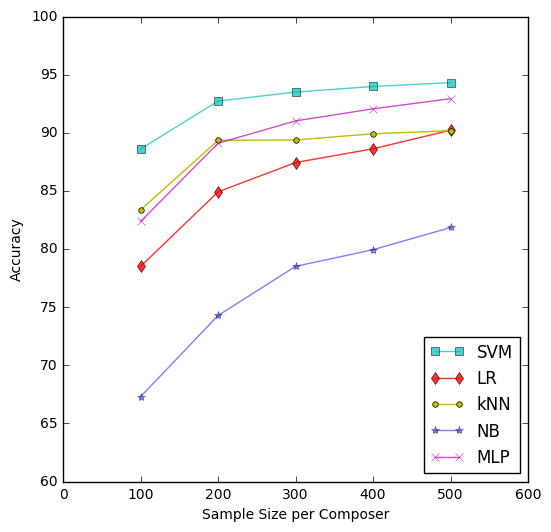

In [80]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(6,6))

plt.axis([0, 600, 60, 100])
plt.xlabel('Sample Size per Composer')
plt.ylabel('Accuracy')

x = np.array([100, 200, 300, 400, 500])
plt.plot(x, [88.60, 92.73, 93.50, 93.98, 94.31], 'c-s', label='SVM', alpha=0.7)
plt.plot(x, [78.50, 84.92, 87.44, 88.62, 90.22], 'r-d', label='LR', alpha=0.8)
plt.plot(x, [83.37, 89.35, 89.38, 89.91, 90.18], 'y-o', label='kNN', markersize=4)
plt.plot(x, [67.30, 74.28, 78.51, 79.94, 81.85], 'b-*', label='NB', alpha=0.5)
plt.plot(x, [82.37, 89.10, 91.02, 92.06, 92.93], 'm-x', label='MLP', alpha=0.7)
plt.legend(loc=0)
# plt.show()

plt.savefig('classifier-benchmark.png')

# note that LR actually gives better results in smaller (100~500 per composer) sets.
# the disproportionate amount of training data (2119 pieces and 662671 chords for Bach, 598 and 167106 for Scarlatti)
# seems to result in 24% of Scarlatti being misclassified as Bach? Further work will be needed to investigate this.

In [357]:
# MINDF, MAXDF = 1, 0.95 # via experimentation

# NGRAMRANGES = [(1,2)]
# FEATURES = ['chordorders']
# VECTORIZERS = [TfidfVectorizer(lowercase=False, token_pattern=u"(?u)\\b\\w+\\b", sublinear_tf=True)]
# # CLASSIFIERS = [svm.LinearSVC(penalty='l2', C=5),
# #                neighbors.KNeighborsClassifier(weights='distance'),
# #                neighbors.KNeighborsClassifier(n_neighbors=10, weights='distance')]
# for i in range(5):
#     print(i+1)
#     CLASSIFIERS = [neighbors.KNeighborsClassifier(weights='distance', n_neighbors=i+1)]
#     benchmark_parameters_threeclass(BACH, SCARLATTI, BEETHOVEN, 100)

In [356]:
# MINDF, MAXDF = 1, 0.95 # via experimentation

# NGRAMRANGES = [(1,2)]
# FEATURES = ['chordorders']
# VECTORIZERS = [TfidfVectorizer(lowercase=False, token_pattern=u"(?u)\\b\\w+\\b", sublinear_tf=True)]
# CLASSIFIERS = [svm.LinearSVC(penalty='l2', C=5, loss='hinge'),
#                linear_model.LogisticRegression(penalty='l2', C=100, tol=1),
#                linear_model.RidgeClassifier(alpha=0.0001),
#                naive_bayes.MultinomialNB(alpha=0.00001, fit_prior=False)]#,
# #                neural_network.MLPClassifier(solver='lbfgs',hidden_layer_sizes=(10,))] 

# benchmark_parameters_threeclass(BACH, SCARLATTI, BEETHOVEN)